In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, Adagrad
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Data Loading

In [2]:
data = pd.read_csv('synthetic_traffic_data_with_congestion.csv')

In [3]:
data

,Time,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility,Road_Condition,Traffic_Congestion
0,2024-01-01 00:00:00,102.0,95.208871,71.489953,24.730232,6.641042,1.613307,4.843614,5.615359,Snowy,Low
1,2024-01-01 01:00:00,435.0,22.227414,57.897765,8.805837,17.086020,27.731161,6.546673,0.003330,Snowy,Medium
2,2024-01-01 02:00:00,860.0,110.130299,1.460900,23.678285,31.112068,19.851620,19.707152,1.142456,Wet,High
3,2024-01-01 03:00:00,270.0,50.943291,36.037549,33.260058,32.069929,26.598680,7.363360,3.751952,Dry,Low
4,2024-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Snowy,Low
...,...,...,...,...,...,...,...,...,...,...,...
2995,2024-05-04 19:00:00,908.0,8.085225,19.574603,-9.857157,39.042333,29.211387,1.396254,9.959174,Dry,High
2996,2024-05-04 20:00:00,158.0,99.784894,82.674243,33.180766,38.136846,14.165901,3.205072,9.941294,Wet,Low
2997,2024-05-04 21:00:00,582.0,21.279186,83.076739,16.645546,26.269763,11.807877,8.543912,4.240304,Wet,Medium
2998,2024-05-04 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wet,High


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                3000 non-null   object 
 1   Traffic_Flow        2700 non-null   float64
 2   Average_Speed       2700 non-null   float64
 3   Occupancy           2700 non-null   float64
 4   Temperature         2700 non-null   float64
 5   Humidity            2700 non-null   float64
 6   Wind_Speed          2700 non-null   float64
 7   Precipitation       2700 non-null   float64
 8   Visibility          2700 non-null   float64
 9   Road_Condition      2850 non-null   object 
 10  Traffic_Congestion  3000 non-null   object 
dtypes: float64(8), object(3)
memory usage: 257.9+ KB


In [5]:
data.describe()

,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,502.494444,59.921518,49.843010,12.754635,49.845469,14.942475,9.945241,5.010733
std,294.856683,34.644438,28.817498,12.924307,28.651388,8.575421,5.799578,2.892501
min,0.000000,0.022383,0.062752,-9.953997,0.011864,0.005265,0.000186,0.003330
25%,243.000000,29.808424,25.456106,1.962071,25.582698,7.648250,4.789890,2.523476
50%,502.000000,60.362272,50.356672,12.936843,49.857398,14.813953,9.949895,4.921099
75%,763.000000,90.024442,74.385113,23.876495,74.001263,22.121859,14.974315,7.577471
max,998.000000,119.965656,99.984924,34.988357,99.966964,29.996780,19.993897,9.995181


In [6]:
#Remove null values in all the features by dropping those rows which have NAN value
data.dropna(subset=['Traffic_Flow','Average_Speed','Occupancy','Temperature','Humidity','Wind_Speed','Precipitation','Visibility','Road_Condition','Traffic_Congestion'],inplace=True)
    

In [7]:
X = data.drop('Traffic_Congestion', axis=1)
y = data['Traffic_Congestion']

In [8]:
def preprocessing(data):
    data = data.drop('Time', axis=1)
    
    numerical_cols=['Traffic_Flow','Average_Speed','Occupancy','Temperature','Humidity','Wind_Speed','Precipitation','Visibility']
    numerical_data=data[numerical_cols]
    categorical_cols=['Road_Condition']
    categorical_data=data[categorical_cols]
    
    #Scaling the numerical data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_data)
    
    #Normalizing categorical data
    encoder = OneHotEncoder(sparse=False)  # Drop first category to avoid dummy trap
    encoded_data = encoder.fit_transform(categorical_data)
    
    transformed_data = pd.concat([pd.DataFrame(scaled_data, columns=numerical_cols), 
                             pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))], axis=1)

    return transformed_data

In [9]:
X=preprocessing(X)

C:\Users\vedas\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
X

,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility,Road_Condition_Dry,Road_Condition_Icy,Road_Condition_Snowy,Road_Condition_Wet
0,-1.357866,1.014753,0.756119,0.924066,-1.501430,-1.557395,-0.885412,0.208669,0.0,0.0,1.0,0.0
1,-0.225056,-1.092510,0.283713,-0.306411,-1.138024,1.496857,-0.590370,-1.720268,0.0,0.0,1.0,0.0
2,1.220722,1.445593,-1.677792,0.842782,-0.650023,0.575415,1.689582,-1.328734,0.0,0.0,0.0,1.0
3,-0.786358,-0.263369,-0.476055,1.583165,-0.616697,1.364423,-0.448885,-0.431812,1.0,0.0,0.0,0.0
4,-1.463323,1.092163,-0.381951,-0.930490,0.435543,-1.285472,1.214678,-1.262454,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2563,-1.575583,0.308772,-1.601257,-0.591957,1.276375,-1.684678,-1.390235,0.250052,0.0,0.0,0.0,1.0
2564,1.384010,-1.500851,-1.048237,-1.748499,-0.374110,1.669956,-1.482640,1.701702,1.0,0.0,0.0,0.0
2565,-1.167363,1.146881,1.144838,1.577038,-0.405614,-0.089480,-1.169277,1.695556,0.0,0.0,0.0,1.0
2566,0.275013,-1.119889,1.158827,0.299363,-0.818499,-0.365230,-0.244364,-0.263958,0.0,0.0,0.0,1.0


In [11]:
print(data.isnull().sum())

Time                  0
Traffic_Flow          0
Average_Speed         0
Occupancy             0
Temperature           0
Humidity              0
Wind_Speed            0
Precipitation         0
Visibility            0
Road_Condition        0
Traffic_Congestion    0
dtype: int64


In [12]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert encoded labels to one-hot encoding (for use in classification models)
y_categorical = to_categorical(y_encoded)

In [13]:
# Print the original labels and their corresponding encoded values
print("Original labels:", y[:5])
print("Encoded labels:", y_encoded[:5])
print("One-hot encoded labels:\n", y_categorical[:5])


Original labels: 0       Low
1    Medium
2      High
3       Low
5       Low
Name: Traffic_Congestion, dtype: object
Encoded labels: [1 2 0 1 1]
One-hot encoded labels:
 [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Constructing autoencoder architecture

In [15]:

# Define the size of the input
input_dim = X_train.shape[1]
encoding_dim = 10  # Size of the encoded representation

# Define the autoencoder model
input_layer = layers.Input(shape=(input_dim,))
# Encoder
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
# Decoder
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = models.Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Encoder model to reduce features
encoder = models.Model(inputs=input_layer, outputs=encoded)


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9130 - val_loss: 0.8467
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8450 - val_loss: 0.7893
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7946 - val_loss: 0.7408
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7339 - val_loss: 0.7004
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7005 - val_loss: 0.6674
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6603 - val_loss: 0.6404
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6363 - val_loss: 0.6183
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6229 - val_loss: 0.5995
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6043 - val_loss: 0.5833
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5791 - val_loss: 0.5691
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5559 - val_loss: 0.5567
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5641 - val_lo

In [16]:
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [17]:
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(2054, 10)
(514, 10)


# Neural Network model

In [18]:
def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=(input_shape,)),  #Input layer
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')  #Classification layer
    ])
    return model

# Full Batch Gradient Descent

In [19]:
num_classes = y_categorical.shape[1]
model_full_batch = build_model(X_train_encoded.shape[1],num_classes)
model_full_batch.compile(optimizer='adam', loss='categorical_crossentropy')
fullbatch_losses=[]
fullbatch_Ttime=[]
batch_size = len(X_train)
for optimizer in [Adam(), Adagrad()]:
    start_time = time.time()
    model_full_batch.fit(X_train_encoded, y_train, epochs=100, batch_size=batch_size , verbose=0)
    end_time = time.time()
    training_time=end_time - start_time
    
    # Evaluate the model on the test set
    loss = model_full_batch.evaluate(X_test_encoded, y_test, verbose=0)

    print(f"Optimizer: {optimizer.__class__.__name__}, Batch Size: {batch_size}, Loss: {loss}")
    print(f"Training Time: {training_time:.2f} seconds")
    fullbatch_Ttime.append(training_time)
    fullbatch_losses.append(loss)

Optimizer: Adam, Batch Size: 2054, Loss: 0.8709897994995117
Training Time: 4.93 seconds
Optimizer: Adagrad, Batch Size: 2054, Loss: 0.41832876205444336
Training Time: 3.34 seconds


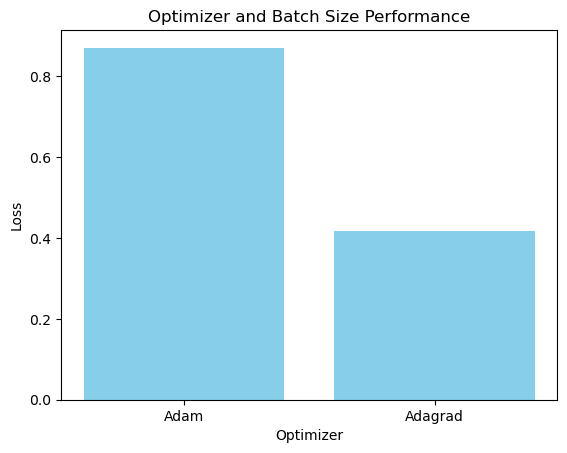

In [20]:
optimizers = ['Adam', 'Adagrad']
batch_sizes = [len(X_train), len(X_train)]

# Create the bar chart
plt.bar(optimizers, fullbatch_losses, color='skyblue')
plt.xlabel('Optimizer')
plt.ylabel('Loss')
plt.title('Optimizer and Batch Size Performance')
plt.show()

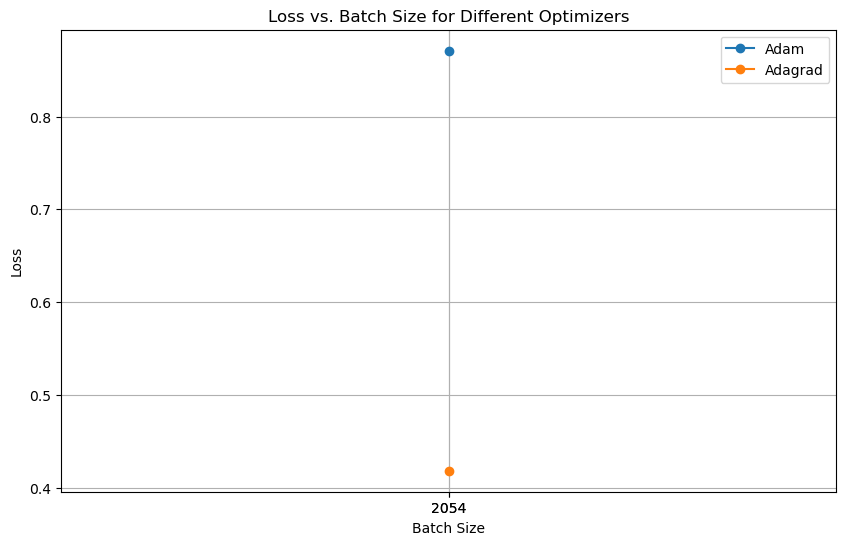

In [21]:
optimizers = ['Adam', 'Adagrad']
batch_sizes = [len(X_train),len(X_train)]

# Plotting the results
plt.figure(figsize=(10, 6))

# Separate plots for each optimizer
plt.plot(batch_sizes[0], fullbatch_losses[0], marker='o', label='Adam')
plt.plot(batch_sizes[1], fullbatch_losses[1], marker='o', label='Adagrad')

# Labels and Title
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.title('Loss vs. Batch Size for Different Optimizers')
plt.xticks(batch_sizes)  
plt.legend()

# Show plot
plt.grid(True)
plt.show()


# Mini-Batch Gradient Descent

In [22]:
num_classes = y_categorical.shape[1]
model_mini_batch = build_model(X_train_encoded.shape[1],num_classes)

# Compile the neural network model
model_mini_batch.compile(optimizer='adam', loss='categorical_crossentropy')
minibatch_losses=[]
minibatch_Ttime=[]
# Train the neural network model using different gradient descent methods and optimizers
for optimizer in [Adam(), Adagrad()]:
    for batch_size in [32, 64, 128]:
        start_time = time.time()
        model_mini_batch.fit(X_train_encoded, y_train, epochs=100, batch_size=batch_size, verbose=0)
        end_time = time.time()
        training_time=end_time - start_time

        # Evaluate the model on the test set
        loss = model_mini_batch.evaluate(X_test_encoded, y_test, verbose=0)
        
        print(f"Optimizer: {optimizer.__class__.__name__}, Batch Size: {batch_size}, Loss: {loss}")
        print(f"Training Time: {training_time:.2f} seconds")
        minibatch_Ttime.append(training_time)
        minibatch_losses.append(loss)

Optimizer: Adam, Batch Size: 32, Loss: 0.2583262026309967
Training Time: 17.89 seconds
Optimizer: Adam, Batch Size: 64, Loss: 0.2867327034473419
Training Time: 9.95 seconds
Optimizer: Adam, Batch Size: 128, Loss: 0.2631051540374756
Training Time: 6.78 seconds
Optimizer: Adagrad, Batch Size: 32, Loss: 0.28185203671455383
Training Time: 16.79 seconds
Optimizer: Adagrad, Batch Size: 64, Loss: 0.3005845546722412
Training Time: 9.92 seconds
Optimizer: Adagrad, Batch Size: 128, Loss: 0.2806105613708496
Training Time: 6.76 seconds


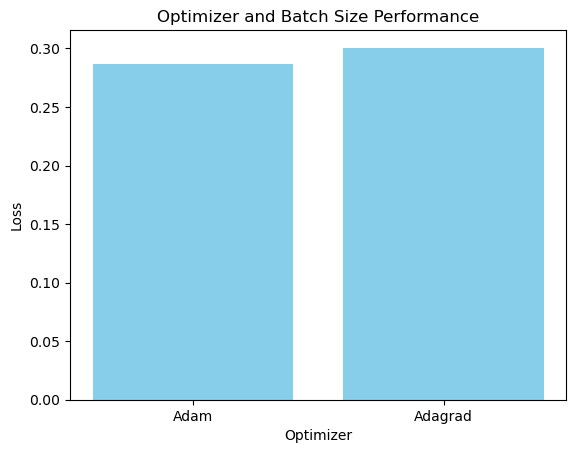

In [23]:
optimizers = ['Adam', 'Adam', 'Adam', 'Adagrad', 'Adagrad', 'Adagrad']
batch_sizes = [32, 64, 128, 32, 64, 128]

# Create the bar chart
plt.bar(optimizers, minibatch_losses, color='skyblue')
plt.xlabel('Optimizer')
plt.ylabel('Loss')
plt.title('Optimizer and Batch Size Performance')
plt.show()

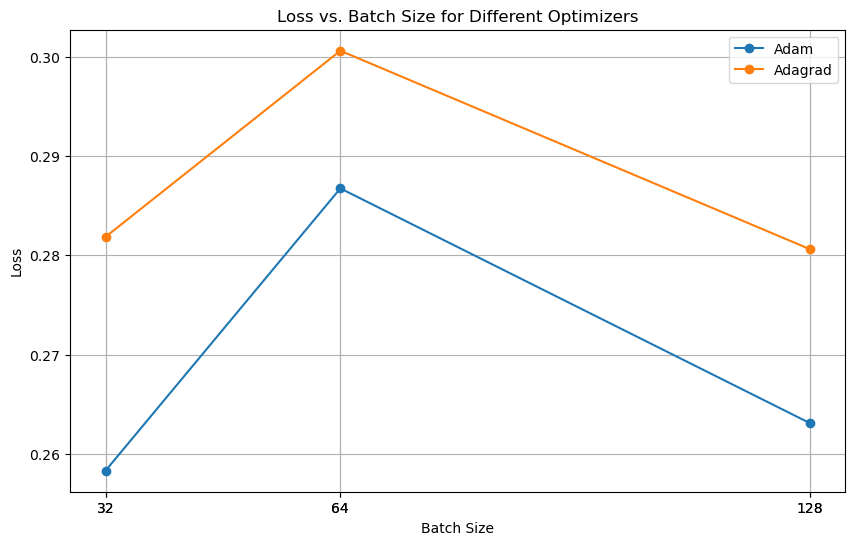

In [24]:
optimizers = ['Adam', 'Adam', 'Adam', 'Adagrad', 'Adagrad', 'Adagrad']
batch_sizes = [32, 64, 128, 32, 64, 128]

# Plotting the results
plt.figure(figsize=(10, 6))

# Separate plots for each optimizer
plt.plot(batch_sizes[:3], minibatch_losses[:3], marker='o', label='Adam')
plt.plot(batch_sizes[3:], minibatch_losses[3:], marker='o', label='Adagrad')

# Labels and Title
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.title('Loss vs. Batch Size for Different Optimizers')
plt.xticks(batch_sizes)  
plt.legend()

# Show plot
plt.grid(True)
plt.show()


# Stochastic Gradient Descent

In [25]:
num_classes = y_categorical.shape[1]
model_stochastic = build_model(X_train_encoded.shape[1],num_classes)

model_stochastic.compile(optimizer='adam', loss='categorical_crossentropy')
stochastic_losses=[]
stochastic_Ttime=[]
batch_size=1
for optimizer in [Adam(), Adagrad()]:
    start_time = time.time()
    model_stochastic.fit(X_train_encoded, y_train, epochs=100, batch_size=batch_size, verbose=0)
    end_time = time.time()
    training_time=end_time - start_time

    # Evaluate the model on the test set
    loss = model_stochastic.evaluate(X_test_encoded, y_test, verbose=0)

    print(f"Optimizer: {optimizer.__class__.__name__}, Batch Size: {batch_size}, Loss: {loss}")
    print(f"Training Time: {training_time:.2f} seconds")
    stochastic_Ttime.append(training_time)
    stochastic_losses.append(loss)

Optimizer: Adam, Batch Size: 1, Loss: 19.02520751953125
Training Time: 356.05 seconds
Optimizer: Adagrad, Batch Size: 1, Loss: 96.68550109863281
Training Time: 365.59 seconds


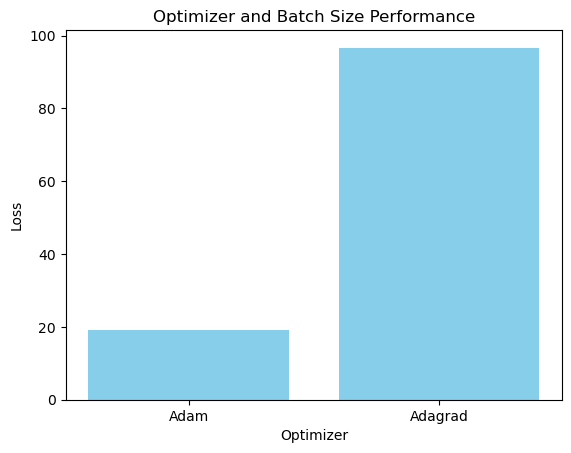

In [26]:
optimizers = ['Adam', 'Adagrad']
batch_sizes = [1, 1]

# Create the bar chart
plt.bar(optimizers, stochastic_losses, color='skyblue')
plt.xlabel('Optimizer')
plt.ylabel('Loss')
plt.title('Optimizer and Batch Size Performance')
plt.show()

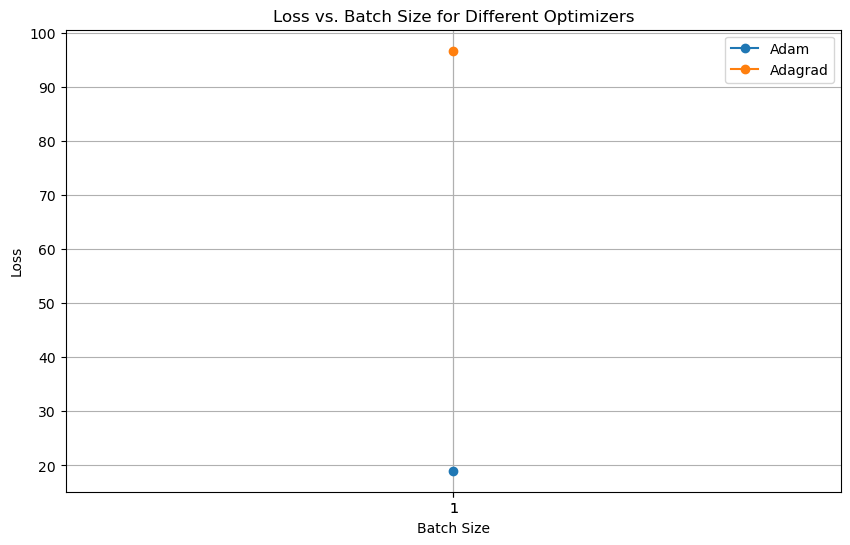

In [27]:
optimizers = ['Adam', 'Adagrad']
batch_sizes = [1,1]

# Plotting the results
plt.figure(figsize=(10, 6))

# Separate plots for each optimizer
plt.plot(batch_sizes[0], stochastic_losses[0], marker='o', label='Adam')
plt.plot(batch_sizes[1], stochastic_losses[1], marker='o', label='Adagrad')

# Labels and Title
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.title('Loss vs. Batch Size for Different Optimizers')
plt.xticks(batch_sizes)  
plt.legend()

# Show plot
plt.grid(True)
plt.show()


Comparing the training time between Full Batch Gradient Descent, Mini-Batch Gradient Descent and Stochastic Gradient Descent

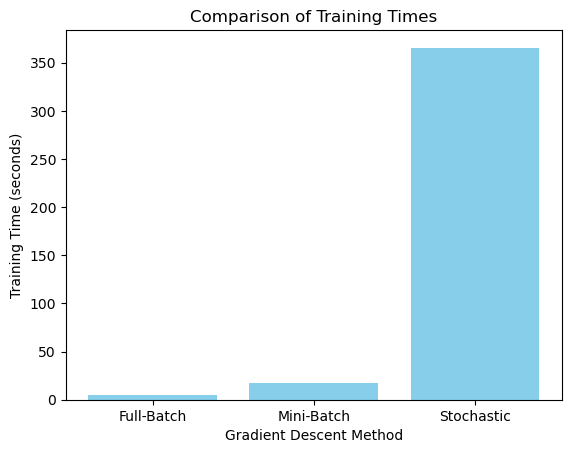

In [28]:

methods = ['Full-Batch', 'Mini-Batch', 'Stochastic']
times = [max(fullbatch_Ttime), max(minibatch_Ttime), max(stochastic_Ttime)]

# Create the bar chart
plt.bar(methods, times, color='skyblue')
plt.xlabel('Gradient Descent Method')
plt.ylabel('Training Time (seconds)')
plt.title('Comparison of Training Times')
plt.show()

Visualizing the convergence of the three models (full-batch, mini-batch, and stochastic gradient descent)

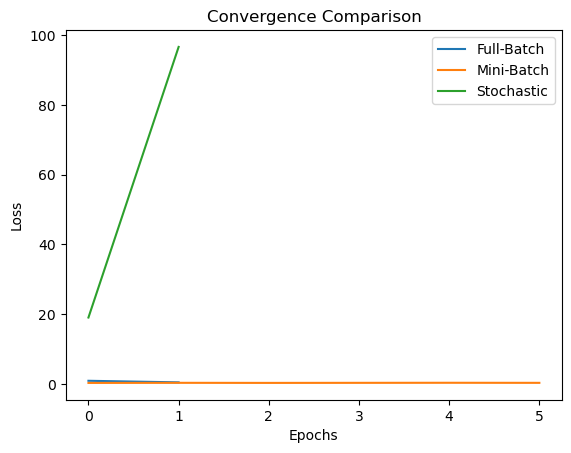

In [29]:
# Create the line chart
plt.plot(fullbatch_losses, label='Full-Batch')
plt.plot(minibatch_losses, label='Mini-Batch')
plt.plot(stochastic_losses, label='Stochastic')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Convergence Comparison')
plt.legend()
plt.show()

using the trained models to make predictions on the test data.

In [30]:
# Predict using the Full Batch Gradient Descent model
predictions_full_batch = model_full_batch.predict(X_test_encoded)
predicted_classes_full_batch = predictions_full_batch.argmax(axis=-1)

# Predict using the Mini-Batch Gradient Descent model
predictions_mini_batch = model_mini_batch.predict(X_test_encoded)
predicted_classes_mini_batch = predictions_mini_batch.argmax(axis=-1)

# Predict using the Stochastic Gradient Descent model
predictions_stochastic = model_stochastic.predict(X_test_encoded)
predicted_classes_stochastic = predictions_stochastic.argmax(axis=-1)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Prediction accuracy of the three models(full-batch, mini-batch, and stochastic gradient descent)

In [31]:
# Convert y_test back from one-hot encoding to class labels
y_test_classes = y_test.argmax(axis=-1)

# Evaluate Full Batch Gradient Descent Model
accuracy_full_batch = accuracy_score(y_test_classes, predicted_classes_full_batch)
print(f"Full Batch Gradient Descent - Accuracy: {accuracy_full_batch}")
print(classification_report(y_test_classes, predicted_classes_full_batch))

# Evaluate Mini-Batch Gradient Descent Model
accuracy_mini_batch = accuracy_score(y_test_classes, predicted_classes_mini_batch)
print(f"Mini-Batch Gradient Descent - Accuracy: {accuracy_mini_batch}")
print(classification_report(y_test_classes, predicted_classes_mini_batch))

# Evaluate Stochastic Gradient Descent Model
accuracy_stochastic = accuracy_score(y_test_classes, predicted_classes_stochastic)
print(f"Stochastic Gradient Descent - Accuracy: {accuracy_stochastic}")
print(classification_report(y_test_classes, predicted_classes_stochastic))


Full Batch Gradient Descent - Accuracy: 0.8229571984435797
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       171
           1       1.00      0.77      0.87       182
           2       0.73      0.69      0.71       161

    accuracy                           0.82       514
   macro avg       0.83      0.82      0.82       514
weighted avg       0.84      0.82      0.82       514

Mini-Batch Gradient Descent - Accuracy: 0.9124513618677043
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       171
           1       0.93      0.96      0.95       182
           2       0.87      0.84      0.86       161

    accuracy                           0.91       514
   macro avg       0.91      0.91      0.91       514
weighted avg       0.91      0.91      0.91       514

Stochastic Gradient Descent - Accuracy: 0.26653696498054474
              precision    recall  f1-score   support

     

Use the models to make predictions for new data points

In [32]:
new_data={'Time':['2024-01-01 07:00:00','2024-01-01 11:00:00','2024-01-01 12:00:00','2024-01-01 19:00:00','2024-01-01 21:00:00'],
          'Traffic_Flow':[20.0,661.0,308.0,784.0,34.0],
          'Average_Speed':[63.17,89.23,24.76,34.09,23.09],
          'Occupancy':[30.88,84.02,74,23.24,24.6],
          'Temperature':[17.16,9.35,7.49,5.34,9.45],
          'Humidity':[21.12,74.83,23.94,99.24,34.45],
          'Wind_Speed':[26.99,23.54,45.09,89.23,75.43],
          'Precipitation':[6.48,9.23,3.34,7.24,7.45],
          'Visibility':[4.29,9.24,5.34,3.54,2.44],
          'Road_Condition':['Dry','Snowy','Dry','Wet','Icy']}
new_data=pd.DataFrame(new_data)
new_data

,Time,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility,Road_Condition
0,2024-01-01 07:00:00,20.0,63.17,30.88,17.16,21.12,26.99,6.48,4.29,Dry
1,2024-01-01 11:00:00,661.0,89.23,84.02,9.35,74.83,23.54,9.23,9.24,Snowy
2,2024-01-01 12:00:00,308.0,24.76,74.00,7.49,23.94,45.09,3.34,5.34,Dry
3,2024-01-01 19:00:00,784.0,34.09,23.24,5.34,99.24,89.23,7.24,3.54,Wet
4,2024-01-01 21:00:00,34.0,23.09,24.60,9.45,34.45,75.43,7.45,2.44,Icy


In [33]:
new_data=preprocessing(new_data)
new_data

C:\Users\vedas\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Traffic_Flow,Average_Speed,Occupancy,Temperature,Humidity,Wind_Speed,Precipitation,Visibility,Road_Condition_Dry,Road_Condition_Icy,Road_Condition_Snowy,Road_Condition_Wet
0,-1.085098,0.636707,-0.629207,1.853823,-0.955852,-0.958669,-0.139021,-0.291130,1.0,0.0,0.0,0.0
1,0.952242,1.654531,1.401160,-0.102183,0.778802,-1.090617,1.287498,1.828128,0.0,0.0,1.0,0.0
2,-0.169725,-0.863471,1.018317,-0.568018,-0.864775,-0.266420,-1.767846,0.158409,1.0,0.0,0.0,0.0
3,1.343183,-0.499070,-0.921116,-1.106483,1.567163,1.421749,0.255217,-0.612230,0.0,0.0,0.0,1.0
4,-1.040601,-0.928697,-0.869153,-0.077138,-0.525337,0.893957,0.364151,-1.083177,0.0,1.0,0.0,0.0


In [34]:
new_data_encoded = encoder.predict(new_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [35]:
# Predict using the Full Batch Gradient Descent model
predictions_full_batch = model_full_batch.predict(new_data_encoded)
predicted_classes_full_batch = predictions_full_batch.argmax(axis=-1)
predicted_labels_full_batch = label_encoder.inverse_transform(predicted_classes_full_batch)
print("Predictions made by full batch gradient descent model: Traffic_Congestion -",predicted_labels_full_batch)

# Predict using the Mini-Batch Gradient Descent model
predictions_mini_batch = model_mini_batch.predict(new_data_encoded)
predicted_classes_mini_batch = predictions_mini_batch.argmax(axis=-1)
predicted_labels_mini_batch = label_encoder.inverse_transform(predicted_classes_mini_batch)
print("Predictions made by mini batch gradient descent model: Traffic_Congestion -",predicted_labels_mini_batch)

# Predict using the Stochastic Gradient Descent model
predictions_stochastic = model_stochastic.predict(new_data_encoded)
predicted_classes_stochastic = predictions_stochastic.argmax(axis=-1)
predicted_labels_stochastic = label_encoder.inverse_transform(predicted_classes_stochastic)
print("Predictions made by stochastic gradient descent model: Traffic_Congestion -",predicted_labels_stochastic)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predictions made by full batch gradient descent model: Traffic_Congestion - ['Low' 'High' 'Medium' 'High' 'Low']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predictions made by mini batch gradient descent model: Traffic_Congestion - ['Low' 'High' 'Medium' 'High' 'Low']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predictions made by stochastic gradient descent model: Traffic_Congestion - ['High' 'Low' 'High' 'Medium' 'Medium']
